# Part B: Deep Learning
Submitted by : Lim Yuan Her (P7359221)

## 0. Introduction
- The goal is to classify handwriting digits. This is a typical image classification problem and a deep learning model will be built with the aim of achieving minimal error rate less than the baseline.

## 1. Preparation

In [0]:
%tensorflow_version 1.x

### 1.1 Suppress warning messages

In [0]:
import warnings
import tensorflow as tf

warnings.filterwarnings('ignore')

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### 1.2 Disable auto-scrolling

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### 1.3 Load Libraries

In [4]:
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

     / 68.5MB 2.3MB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=b647b63298a0194ddbb461600cce303cf1115cfbf92c8cafc9efd099f46a4e7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wj28xef2/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [5]:
import sklearn
import numpy as np
import pandas as pd
import datetime
import random
import math
import itertools
import matplotlib
import platform
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import axes
import seaborn as sns
import keras

from keras import models
from keras import callbacks
from keras import regularizers
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from keras.layers import Input
from keras.layers import Add
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Activation
from keras import activations
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
from keras.utils.vis_utils import plot_model

from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
from vis.visualization import visualize_cam, overlay
from vis.utils import utils

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Keras version={}".format(keras.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Python version={}".format(platform.python_version()))

Using TensorFlow backend.


************************
        Versions        
************************
Keras version=2.2.5
Numpy version=1.17.5
Pandas version=0.25.3
Matplotlib version=3.1.3
Seaborn version=0.10.0
Python version=3.6.9


## 2. Dataset Loading

In [6]:
from keras.datasets import mnist

# load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## 3. Visualizations

### 3.1 Image Visualization

<Figure size 1152x1152 with 0 Axes>

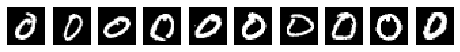

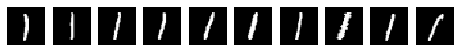

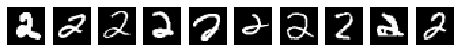

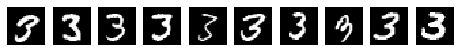

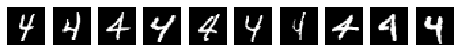

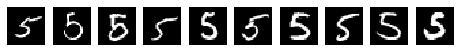

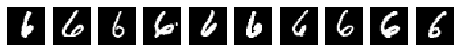

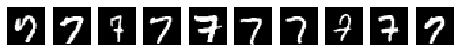

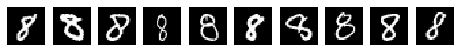

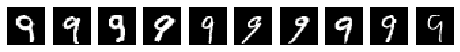

In [7]:
w=25
h=25
fig=plt.figure(figsize=(16, 16))
columns = 10
rows = 1

for key in range(0,10):
  idx = np.where(y_train == key)[0].tolist()
  fig=plt.figure(figsize=(8, 8))
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      plt.axis('off')
      choice = random.randint(0, 1000)
      plt.imshow(X_train[idx[choice]], cmap=plt.get_cmap('gray'), interpolation='none')
  plt.show()

## 4. Data Preprocessing

### 4.1 Image Data Format

In [8]:
if K.image_data_format() == 'channels_first':
    print("channels_first")
    # reshape to be [samples][pixels][rows][columns]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    inputShape = (1,28,28)
else:
    print('channels_last')
    # reshape to be [samples][rows][columns][pixels]
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    inputShape = (28,28,1)

channels_last


### 4.2 Pixel Value Normalization/ Class Vector to Binary Class Matrices Conversion

In [0]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## 5. Model Training

### 5.1 Model Training Helper Functions

#### 5.1.1 General

In [0]:
batch_size = 32
num_classes = 10
epochs = 25

names = [str(i) for i in range(0,10)]

In [0]:
# Model Training Helper Function
def TrainModel(modelName, model, x_train, y_train, x_test, y_test, useEarlyStopping=False): 
    
  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
    
  model_checkpoints = callbacks.ModelCheckpoint("weights_{epoch:02d}_{val_loss:.2f}.h5", monitor='val_loss',
                                                      verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
  csv_logger = CSVLogger(modelName + '_training.log')
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
  
  if(useEarlyStopping == True):
    callbacks_ = [model_checkpoints, csv_logger, early_stopping]
  else:
    callbacks_ = [model_checkpoints, csv_logger]
  
  now = datetime.datetime.now
  t = now()
  
  model_log = model.fit(x_train, y_train,
                   batch_size=batch_size, # number of samples to be used for each gradient update
                   epochs=epochs, # number of iterations over the entire x_train data
                   validation_data=(x_test, y_test), # on which to evaluate loss and model metrics at the end of each epoch
                   verbose=0,
                   callbacks=callbacks_)
  training_time = now() - t
  return model, model_log, training_time

In [0]:
# Plots the accuracy and loss curves from a single model training log
def plotAccuracyLoss(model_log):
  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,3))

  for ax in [ax1, ax2]:
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

  ax1.plot(model_log.history['acc'])
  ax1.plot(model_log.history['val_acc'])
  ax1.set_title('Accuracy (Higher Better)')
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(['train', 'validation'], loc='lower right')

  ax2.plot(model_log.history['loss'])
  ax2.plot(model_log.history['val_loss'])
  ax2.set_title('Loss (Lower Better)')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(['train', 'validation'], loc='upper right')

In [0]:
# Plots the accuracy and loss curves from multiple model training logs for comparison
def plotAccuracyLossComparison(model_logs):   
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,5))

  for ax in [ax1, ax2, ax3, ax4]:
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

  for key in model_logs.keys(): 
    ax1.plot(model_logs[key].history['acc'])
    ax1.set_facecolor('white')
    ax1.set_title('Accuracy (Higher Better)')
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(model_logs.keys(), loc='lower right')
    
    ax2.plot(model_logs[key].history['val_acc'])
    ax2.set_facecolor('white')
    ax2.set_title('Accuracy (Higher Better)')
    ax2.set(xlabel='Epoch', ylabel='Accuracy')
    ax2.legend(model_logs.keys(), loc='lower right')

    ax3.plot(model_logs[key].history['loss'])
    ax3.set_facecolor('white')
    ax3.set_title('Loss (Lower Better)')
    ax3.set(xlabel='Epoch', ylabel='Loss')
    ax3.legend(model_logs.keys(), loc='upper right')
    
    ax4.plot(model_logs[key].history['val_loss'])
    ax4.set_facecolor('white')
    ax4.set_title('Loss (Lower Better)')
    ax4.set(xlabel='Epoch', ylabel='Loss')
    ax4.legend(model_logs.keys(), loc='upper right')

In [0]:
# Plots the confusion matrix for specified model and test datasets
def plotConfusionMatrix(modelName, model, x_test, y_test):
  # Confusion matrix result
  Y_pred = model.predict(x_test, verbose=2)
  y_pred = np.argmax(Y_pred, axis=1)

  cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)

  # Visualizing of confusion matrix
  import seaborn as sn
  import pandas  as pd

  df_cm = pd.DataFrame(cm, columns=names, index = names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  
  df_cm.to_csv(modelName + "_CM.csv")
    
  plt.figure(figsize = (10,10))
  plt.ylabel = 'Actual'
  plt.xlabel ='Predicted'
  sn.set(font_scale=1.4)#for label size

  ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 11}, fmt='g')# font size
  ax.collections[0].colorbar.set_label("Quantity")
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')

  plt.show()
  
  return y_pred, y_test, df_cm

In [0]:
# Prints the classification report based on predicted and actual dataset labels
def plotClassificationReport(y_pred, y_test, names):
  report = classification_report(y_true=np.argmax(y_test,axis=1), 
                                             y_pred=y_pred, 
                                             target_names=names) 
  report_data = []
  lines = report.split('\n')

  #Individual class metric
  for line in lines[2:12]:
    row = {}
    cr_data = line.split(' ') 
    row['class'] = cr_data[11]
    row['precision'] = float(cr_data[18])
    row['recall'] = float(cr_data[24])
    row['f1_score'] = float(cr_data[30])
    report_data.append(row)

  # Macro-weighted avg metric
  for line in lines[14:15]:
    row = {}
    cr_data = line.split(' ') 
    row['class'] = 'MacroAvg'
    row['precision'] = float(cr_data[11])
    row['recall'] = float(cr_data[17])
    row['f1_score'] = float(cr_data[23])
    report_data.append(row)

  df_cr = pd.DataFrame.from_dict(report_data)

  print(report)

  return df_cr

In [0]:
# Prints the loss and accuracy scores for evaluated model
def printTestStats(model, x_test, y_test):
  score = model.evaluate(x_test, y_test, verbose=0)
  TestLoss = score[0] * 100
  TestAccuracy = score[1] * 100
  print('Test loss:', '{:.2f}'.format(TestLoss))
  print('Test accuracy:', '{:.2f}'.format(TestAccuracy))
  return TestLoss, TestAccuracy

In [0]:
# Helper function for plotting misclassified images
def PlotClassifications(model, x_test, y_test, misclassified=False):  

  # Get list of predicted classes for x_test by the LeNet model
  y_pred = model.predict_classes(x_test).tolist()

  # Get list of ground truth labels for x_test
  y_actual = np.argmax(y_test,axis=-1).tolist()

  # Get indices where predicted is different from actual
  if(misclassified):
    idx_classified = [i for i, item in enumerate(y_actual) if item != y_pred[i]]
  else:
    idx_classified = [i for i, item in enumerate(y_actual) if item == y_pred[i]]

  plt.rcParams["figure.figsize"] = (5,5)

  x_test_ = x_test.reshape(x_test.shape[0],28,28).astype(float)

  # print 10 images of cats that are predicted as dogs by the LeNet model
  for i in range(3):
    for j in range(3):
      plt.subplot2grid((3,3), (i,j))
      plt.axis('off')
      choice = random.randint(0, len(idx_classified)-1)
      plt.imshow(x_test_[idx_classified[choice]], cmap=plt.get_cmap('gray'), interpolation='none')
      plt.title("Predicted: " + str(y_pred[idx_classified[choice]]) + "\nActual: " + str(y_actual[idx_classified[choice]]), fontsize=14)
    plt.show()

#### 5.1.2 Model-Specific Creation

##### 5.1.2.1 Custom

In [0]:
# Creates Customized Neural Network model based on input parameters
def createNN_Custom(init_mode='glorot_uniform', activation='relu', neurons=8, dropout=0.0):
  feature_layers = [
    Conv2D(32, kernel_size=(5,5), 
           strides=(1,1),
           padding='same', # adds sufficient padding to the input so that the output has same dimension as input
           input_shape=inputShape,
           use_bias=True, 
           kernel_initializer=init_mode,
           bias_initializer='zeros'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(dropout),
    BatchNormalization(),
    Flatten()
  ]

  classification_layers = [
    Dense(neurons),
    Activation(activation),
    Dense(num_classes),
    Activation('softmax', name='visualized_layer')
  ]

  model = Sequential(feature_layers + classification_layers)
  return model

### 5.2 Model Training

In [19]:
# Perform model training using CNN model
model = createNN_Custom() 
model_Custom, model_log_Custom, model_Custom_TrainTime = TrainModel("Custom", model, X_train, y_train, X_test, y_test)


Epoch 00001: val_loss improved from inf to 0.14940, saving model to weights_01_0.15.h5

Epoch 00002: val_loss improved from 0.14940 to 0.11574, saving model to weights_02_0.12.h5

Epoch 00003: val_loss did not improve from 0.11574

Epoch 00004: val_loss improved from 0.11574 to 0.08853, saving model to weights_04_0.09.h5

Epoch 00005: val_loss did not improve from 0.08853

Epoch 00006: val_loss improved from 0.08853 to 0.08612, saving model to weights_06_0.09.h5

Epoch 00007: val_loss did not improve from 0.08612

Epoch 00008: val_loss did not improve from 0.08612

Epoch 00009: val_loss did not improve from 0.08612

Epoch 00010: val_loss did not improve from 0.08612

Epoch 00011: val_loss did not improve from 0.08612

Epoch 00012: val_loss did not improve from 0.08612

Epoch 00013: val_loss did not improve from 0.08612

Epoch 00014: val_loss did not improve from 0.08612

Epoch 00015: val_loss did not improve from 0.08612

Epoch 00016: val_loss did not improve from 0.08612

Epoch 00017

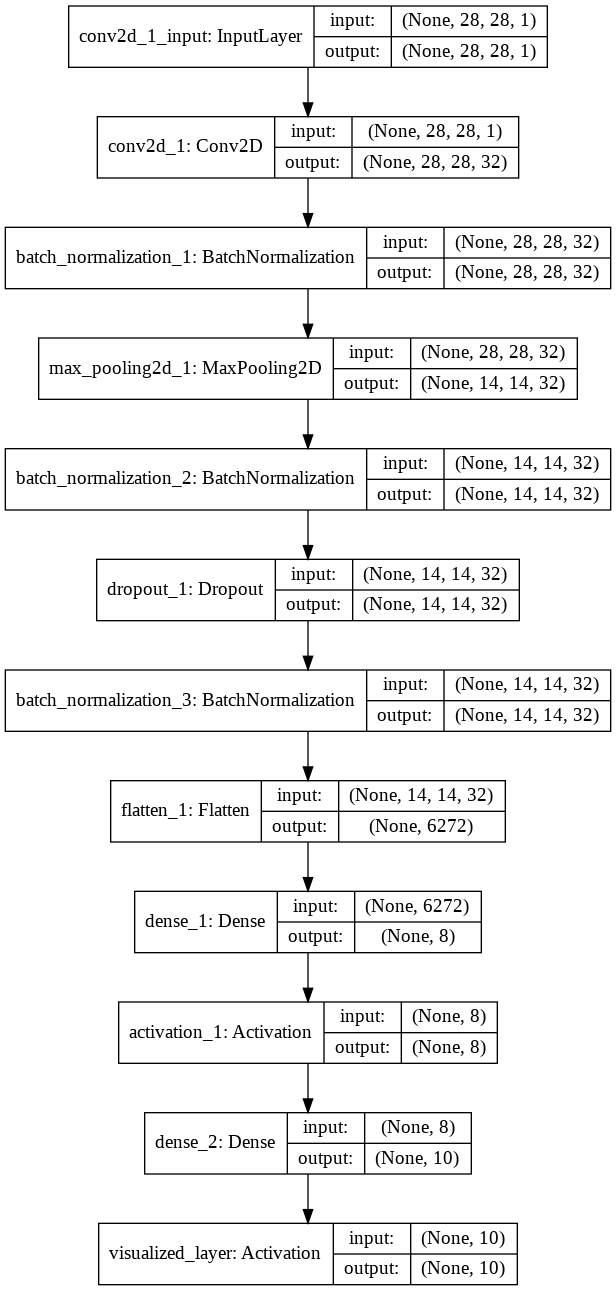

In [20]:
plot_model(model_Custom, to_file='model_custom.png', show_shapes=True, show_layer_names=True)

## 6. Model Evaluation

#### 6.1 Accuracy/ Loss Plots

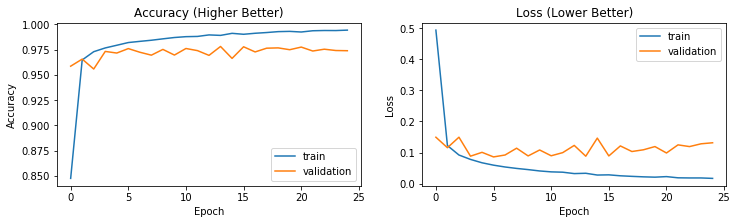

In [21]:
# Plots the accuracy/ loss curves for trained VGG-16 model
plotAccuracyLoss(model_log_Custom)

### 6.2 Confusion Matrix

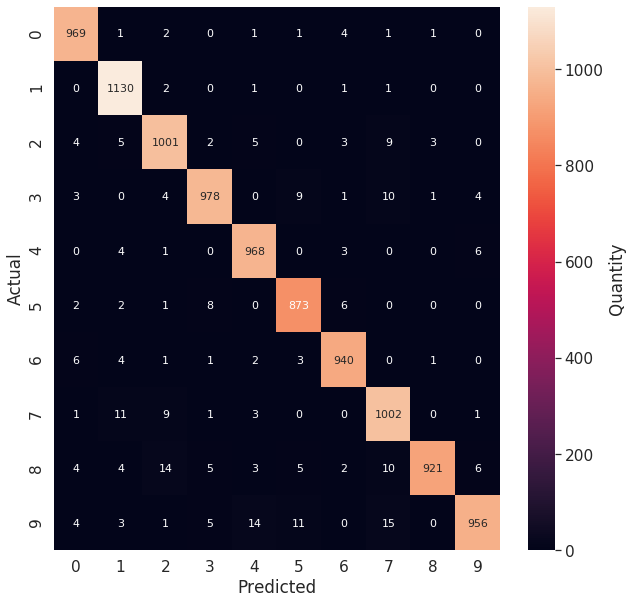

In [22]:
# Plots the confusion matrix for the trained VGG-16 model
Custom_y_pred, Custom_y_test, Custom_CM = plotConfusionMatrix("Custom", model_Custom, X_test, y_test)

### 6.3 Classification Report

In [23]:
# Prints the classification report based on predicted and actual test dataset labels for the VGG-16 model
Custom_CR = plotClassificationReport(Custom_y_pred, Custom_y_test, names)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      1.00      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.97      0.97      1010
           4       0.97      0.99      0.98       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.97      0.97      1028
           8       0.99      0.95      0.97       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### 6.4 Test Dataset Validation

In [24]:
# Evaluates the accuracy and loss scores for the test dataset using the trained VGG-16 model
Custom_test_loss, Custom_test_acc = printTestStats(model_Custom, X_test, y_test)

Test loss: 13.16
Test accuracy: 97.38


### 6.5 Visualizing the wrongly classified data

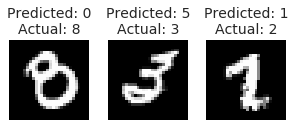

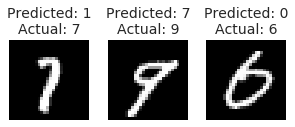

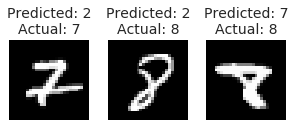

In [25]:
PlotClassifications(model_Custom, X_test, y_test, misclassified=True)

## 7. Model Hyperparameter Tuning

### 7.1. Model Tuning Helper Functions

In [0]:
# Helper function for performing hyperparameter tuning for specified parameters based on LeNet model
def TuneModel(param_name, param_list, batch_size=32, epochs=25, optimizer="SGD", activation="relu", neurons=16, regularization=None, dropout=0.2):
  model_log_list = {}

  for param in param_list:

    if(param_name == "batch_size"):
      model = createNN_Custom()
      batch_size = param
    elif(param_name == "optimizer"):
      model = createNN_Custom()
      optimizer = param
    elif(param_name == "activation"):
      model = createNN_Custom(activation=param)
    elif(param_name == "neurons"):
      model = createNN_Custom(neurons=param)
    elif(param_name == "dropout"):
      model = createNN_Custom(dropout=param)

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=optimizer,
                metrics=['accuracy'])

    now = datetime.datetime.now
    t = now()
    model_checkpoints = callbacks.ModelCheckpoint("weights_{epoch:02d}_{val_loss:.2f}.h5", monitor='val_loss',
                                                      verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    model_log = model.fit(X_train, y_train,
                        batch_size=batch_size, # number of samples to be used for each gradient update
                        epochs=epochs, # number of iterations over the entire x_train data
                        verbose=0, # 0 = Silent
                        validation_data=(X_test, y_test), # on which to evaluate loss and model metrics at the end of each epoch
                        callbacks=[model_checkpoints])

    training_time = now() - t
    print('Training time: %s' % (training_time))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Loss:', score[0]) # the first index of score gives the loss value
    print('Test accuracy:', score[1]) # the second index of score gives the test accuracy

    model_log_list[param] = [training_time, score[0], score[1], model_log]
    
  return model_log_list

In [0]:
# Plots the accuracy/loss/training results for evaluated hyperparameters
def PlotTuningResults(model_log_list, param):
  
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(8,6))

  f.set_size_inches(12, 4)

  for key in model_log_list.keys(): 
    ax1.plot(model_log_list[key][3].history['acc'])
    ax1.set_title('Training Accuracy')
    ax1.title.set_fontsize(16)
    ax1.set_facecolor('white')
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_color('black')
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    #ax1.legend(['train', 'validation'], loc='lower right')
    ax1.legend(model_log_list.keys(), loc='lower right', prop={'size': 12})

    ax2.plot(model_log_list[key][3].history['loss'])
    ax2.set_title('Training Loss')
    ax2.title.set_fontsize(16)
    ax2.set_facecolor('white')
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_color('black')
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(model_log_list.keys(), loc='upper right', prop={'size': 12})

    ax3.plot(model_log_list[key][3].history['val_acc'])
    ax3.set_title('Validation Accuracy')
    ax3.title.set_fontsize(16)
    ax3.set_facecolor('white')
    ax3.spines['left'].set_color('black')
    ax3.spines['bottom'].set_color('black')
    ax3.set(xlabel='Epoch', ylabel='Accuracy')
    ax3.legend(model_log_list.keys(), loc='lower right', prop={'size': 12})

    ax4.plot(model_log_list[key][3].history['val_loss'])
    ax4.set_title('Validation Loss')
    ax4.title.set_fontsize(16)
    ax4.set_facecolor('white')
    ax4.spines['left'].set_color('black')
    ax4.spines['bottom'].set_color('black')
    ax4.set(xlabel='Epoch', ylabel='Loss')
    ax4.legend(model_log_list.keys(), loc='upper right', prop={'size': 12})

  plt.tight_layout()
  plt.show()

  f, (ax_a, ax_b, ax_c) = plt.subplots(1, 3,figsize=(12,6))

  f.set_size_inches(10, 3)

  training_times = [item[0].total_seconds() for item in model_log_list.values()]
  Testing_Losses = [item[1] for item in model_log_list.values()]
  Testing_accuracies = [item[2] for item in model_log_list.values()]

  y_pos = np.arange(len(model_log_list.keys()))
  ax_a.barh(y_pos, training_times, align='center', color='green', ecolor='black')
  ax_a.set_yticks(y_pos)
  ax_a.set_yticklabels(model_log_list.keys())
  ax_a.invert_yaxis()  # labels read top-to-bottom
  ax_a.set_xlabel('Time')
  ax_a.set_title('Training Times')
  ax_a.set_facecolor('white')
  
  ax_b.barh(y_pos, Testing_Losses, align='center', color='green', ecolor='black')
  ax_b.set_yticks(y_pos)
  ax_b.set_yticklabels(model_log_list.keys())
  ax_b.invert_yaxis()  # labels read top-to-bottom
  ax_b.set_xlabel('Loss')
  ax_b.set_title('Testing Losses')
  ax_b.set_facecolor('white')

  ax_c.barh(y_pos, Testing_accuracies, align='center', color='green', ecolor='black')
  ax_c.set_yticks(y_pos)
  ax_c.set_yticklabels(model_log_list.keys())
  ax_c.invert_yaxis()  # labels read top-to-bottom
  ax_c.set_xlabel('Accuracy')
  ax_c.set_title('Testing Accuracies')
  ax_c.set_facecolor('white')

  plt.tight_layout()
  plt.show()

### 7.2. Batch Size

In [28]:
# Perform Batch Size Hyperparameter tuning
batch_size_list = [16, 64, 128]

model_log_list_batch = TuneModel("batch_size", batch_size_list)


Epoch 00001: val_loss improved from inf to 0.14914, saving model to weights_01_0.15.h5

Epoch 00002: val_loss improved from 0.14914 to 0.10937, saving model to weights_02_0.11.h5

Epoch 00003: val_loss improved from 0.10937 to 0.08452, saving model to weights_03_0.08.h5

Epoch 00004: val_loss did not improve from 0.08452

Epoch 00005: val_loss did not improve from 0.08452

Epoch 00006: val_loss did not improve from 0.08452

Epoch 00007: val_loss improved from 0.08452 to 0.07837, saving model to weights_07_0.08.h5

Epoch 00008: val_loss improved from 0.07837 to 0.07770, saving model to weights_08_0.08.h5

Epoch 00009: val_loss did not improve from 0.07770

Epoch 00010: val_loss did not improve from 0.07770

Epoch 00011: val_loss did not improve from 0.07770

Epoch 00012: val_loss did not improve from 0.07770

Epoch 00013: val_loss did not improve from 0.07770

Epoch 00014: val_loss did not improve from 0.07770

Epoch 00015: val_loss did not improve from 0.07770

Epoch 00016: val_loss d

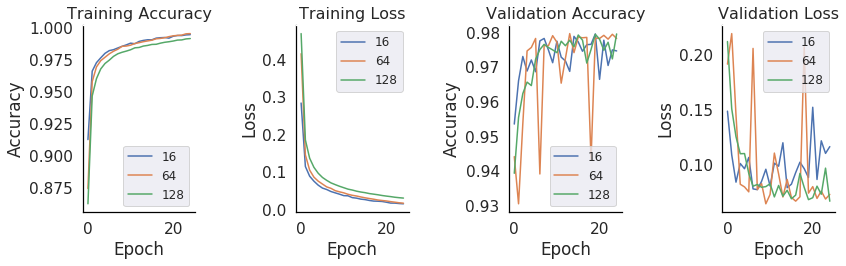

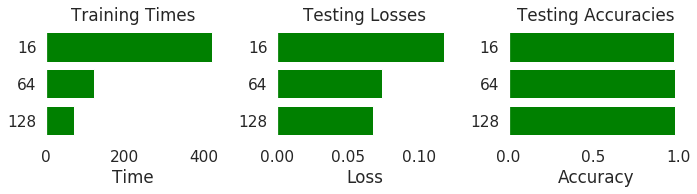

In [29]:
# Plots the results of the Batch Size Hyperparameter Tuning
PlotTuningResults(model_log_list_batch, "Batch Size")

### 7.3. Training Optimization Algorithm

In [30]:
# Perform Optimizer Hyperparameter tuning
optimizer_list = ['Adagrad', 'SGD', 'Adam']

batch_size = 128

model_log_list_optimizer = TuneModel("optimizer", optimizer_list, batch_size=batch_size)


Epoch 00001: val_loss improved from inf to 0.21335, saving model to weights_01_0.21.h5

Epoch 00002: val_loss improved from 0.21335 to 0.12590, saving model to weights_02_0.13.h5

Epoch 00003: val_loss improved from 0.12590 to 0.11572, saving model to weights_03_0.12.h5

Epoch 00004: val_loss improved from 0.11572 to 0.09694, saving model to weights_04_0.10.h5

Epoch 00005: val_loss improved from 0.09694 to 0.09243, saving model to weights_05_0.09.h5

Epoch 00006: val_loss improved from 0.09243 to 0.08541, saving model to weights_06_0.09.h5

Epoch 00007: val_loss improved from 0.08541 to 0.08313, saving model to weights_07_0.08.h5

Epoch 00008: val_loss improved from 0.08313 to 0.08132, saving model to weights_08_0.08.h5

Epoch 00009: val_loss improved from 0.08132 to 0.08002, saving model to weights_09_0.08.h5

Epoch 00010: val_loss did not improve from 0.08002

Epoch 00011: val_loss improved from 0.08002 to 0.07879, saving model to weights_11_0.08.h5

Epoch 00012: val_loss improved 

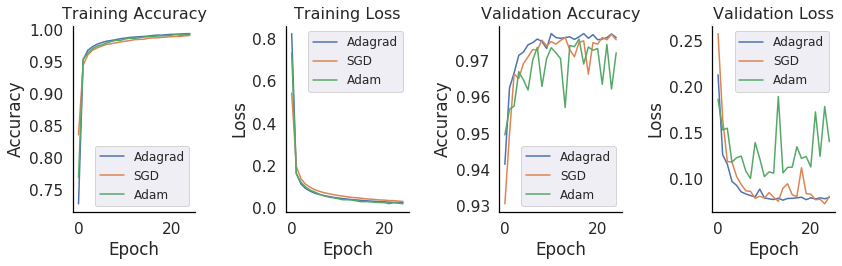

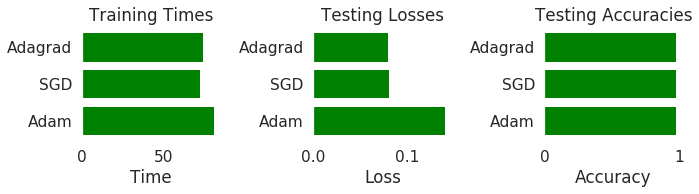

In [31]:
# Plots the results of the Optimizer Hyperparameter Tuning
PlotTuningResults(model_log_list_optimizer, "Optimizer")

### 7.4. Neuron Activation Function

In [32]:
# Perform Neuron Activation Function Hyperparameter tuning

activation_list = ['tanh', 'sigmoid', 'relu']

batch_size = 128
optimizer = 'Adagrad'

model_log_list_activation = TuneModel("activation", activation_list, batch_size=batch_size, optimizer=optimizer)


Epoch 00001: val_loss improved from inf to 0.45987, saving model to weights_01_0.46.h5

Epoch 00002: val_loss improved from 0.45987 to 0.31427, saving model to weights_02_0.31.h5

Epoch 00003: val_loss improved from 0.31427 to 0.25103, saving model to weights_03_0.25.h5

Epoch 00004: val_loss improved from 0.25103 to 0.24398, saving model to weights_04_0.24.h5

Epoch 00005: val_loss improved from 0.24398 to 0.19648, saving model to weights_05_0.20.h5

Epoch 00006: val_loss improved from 0.19648 to 0.18220, saving model to weights_06_0.18.h5

Epoch 00007: val_loss did not improve from 0.18220

Epoch 00008: val_loss improved from 0.18220 to 0.16393, saving model to weights_08_0.16.h5

Epoch 00009: val_loss improved from 0.16393 to 0.15487, saving model to weights_09_0.15.h5

Epoch 00010: val_loss improved from 0.15487 to 0.15107, saving model to weights_10_0.15.h5

Epoch 00011: val_loss improved from 0.15107 to 0.14244, saving model to weights_11_0.14.h5

Epoch 00012: val_loss improved 

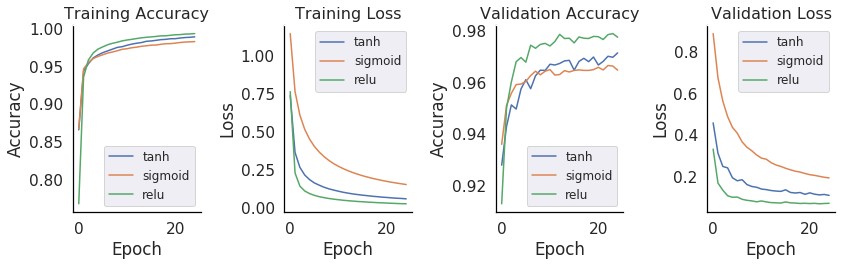

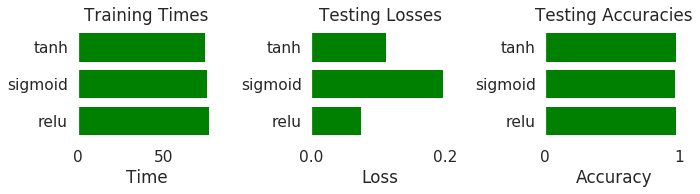

In [33]:
# Plots the results of the Neuron Activation Function Hyperparameter Tuning
PlotTuningResults(model_log_list_activation, "Activation")

### 7.5. Number of Neurons in the Hidden Layer

In [34]:
# Perform Neuron Quantity Hyperparameter tuning

neurons_list = [150, 400, 50]

batch_size = 128
optimizer = 'Adagrad'
activation = 'relu'

model_log_list_neurons = TuneModel("neurons", neurons_list, batch_size=batch_size, optimizer=optimizer, activation=activation)


Epoch 00001: val_loss improved from inf to 0.08745, saving model to weights_01_0.09.h5

Epoch 00002: val_loss improved from 0.08745 to 0.06797, saving model to weights_02_0.07.h5

Epoch 00003: val_loss improved from 0.06797 to 0.06473, saving model to weights_03_0.06.h5

Epoch 00004: val_loss improved from 0.06473 to 0.05758, saving model to weights_04_0.06.h5

Epoch 00005: val_loss did not improve from 0.05758

Epoch 00006: val_loss improved from 0.05758 to 0.05711, saving model to weights_06_0.06.h5

Epoch 00007: val_loss did not improve from 0.05711

Epoch 00008: val_loss did not improve from 0.05711

Epoch 00009: val_loss did not improve from 0.05711

Epoch 00010: val_loss improved from 0.05711 to 0.05689, saving model to weights_10_0.06.h5

Epoch 00011: val_loss did not improve from 0.05689

Epoch 00012: val_loss did not improve from 0.05689

Epoch 00013: val_loss improved from 0.05689 to 0.05626, saving model to weights_13_0.06.h5

Epoch 00014: val_loss did not improve from 0.05

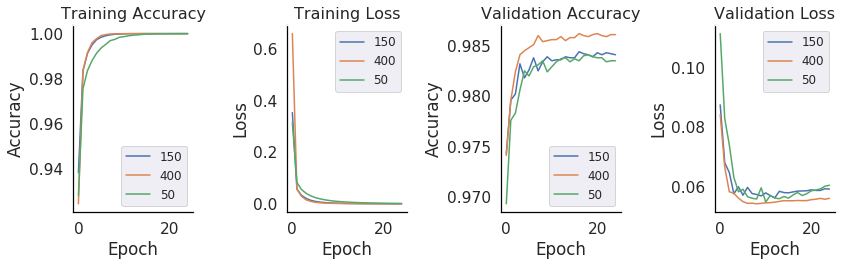

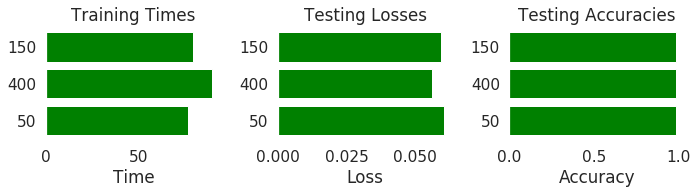

In [35]:
# Plots the results of the Neuron Quantity Hyperparameter Tuning
PlotTuningResults(model_log_list_neurons, "Neurons")

### 7.6. Dropout Rate

In [36]:
# Perform Neuron Quantity Hyperparameter tuning

dropout_list = [0.2, 0.4, 0.6]

batch_size = 128
optimizer = 'Adagrad'
activation = 'relu'
neurons = 400

model_log_list_dropout = TuneModel("dropout", dropout_list, batch_size=batch_size, optimizer=optimizer, activation=activation, neurons=neurons)


Epoch 00001: val_loss improved from inf to 1.11911, saving model to weights_01_1.12.h5

Epoch 00002: val_loss improved from 1.11911 to 0.84290, saving model to weights_02_0.84.h5

Epoch 00003: val_loss improved from 0.84290 to 0.60137, saving model to weights_03_0.60.h5

Epoch 00004: val_loss improved from 0.60137 to 0.28307, saving model to weights_04_0.28.h5

Epoch 00005: val_loss improved from 0.28307 to 0.18761, saving model to weights_05_0.19.h5

Epoch 00006: val_loss improved from 0.18761 to 0.16886, saving model to weights_06_0.17.h5

Epoch 00007: val_loss improved from 0.16886 to 0.15974, saving model to weights_07_0.16.h5

Epoch 00008: val_loss improved from 0.15974 to 0.15465, saving model to weights_08_0.15.h5

Epoch 00009: val_loss did not improve from 0.15465

Epoch 00010: val_loss improved from 0.15465 to 0.14539, saving model to weights_10_0.15.h5

Epoch 00011: val_loss improved from 0.14539 to 0.13281, saving model to weights_11_0.13.h5

Epoch 00012: val_loss improved 

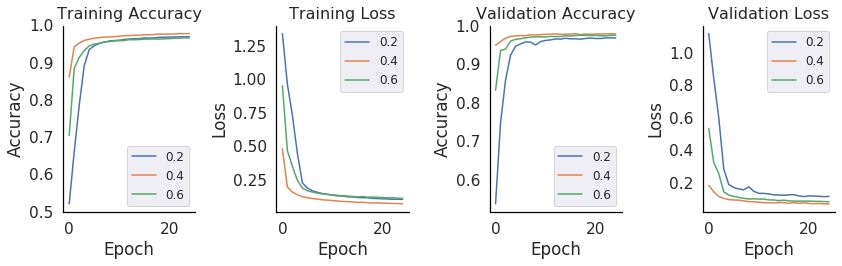

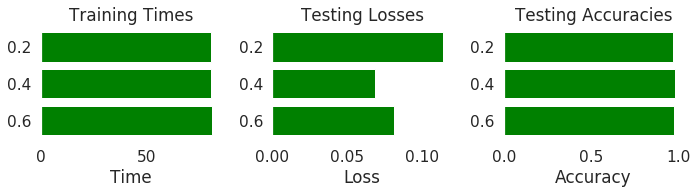

In [37]:
# Plots the results of the Dropout Rate Hyperparameter Tuning
PlotTuningResults(model_log_list_dropout, "Dropout")

### 7.7. Tuned Model Scoring and Evaluation

In [38]:
# Perform model training using tuned model
batch_size = 128
optimizer = 'Adagrad'
model = createNN_Custom(init_mode='glorot_uniform', activation='relu', neurons=400, dropout=0.4)
model_Tuned, model_log_Tuned, model_Tuned_TrainTime = TrainModel("Tuned", model, X_train, y_train, X_test, y_test)


Epoch 00001: val_loss improved from inf to 0.07755, saving model to weights_01_0.08.h5

Epoch 00002: val_loss improved from 0.07755 to 0.05535, saving model to weights_02_0.06.h5

Epoch 00003: val_loss improved from 0.05535 to 0.05038, saving model to weights_03_0.05.h5

Epoch 00004: val_loss did not improve from 0.05038

Epoch 00005: val_loss did not improve from 0.05038

Epoch 00006: val_loss did not improve from 0.05038

Epoch 00007: val_loss did not improve from 0.05038

Epoch 00008: val_loss did not improve from 0.05038

Epoch 00009: val_loss did not improve from 0.05038

Epoch 00010: val_loss did not improve from 0.05038

Epoch 00011: val_loss did not improve from 0.05038

Epoch 00012: val_loss did not improve from 0.05038

Epoch 00013: val_loss did not improve from 0.05038

Epoch 00014: val_loss did not improve from 0.05038

Epoch 00015: val_loss did not improve from 0.05038

Epoch 00016: val_loss did not improve from 0.05038

Epoch 00017: val_loss did not improve from 0.05038


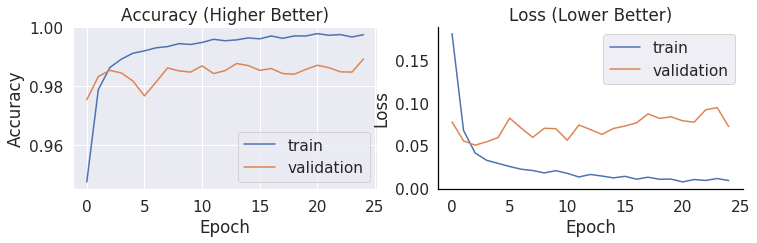

In [39]:
# Plots the accuracy/ loss curves for trained VGG-16 model
plotAccuracyLoss(model_log_Tuned)

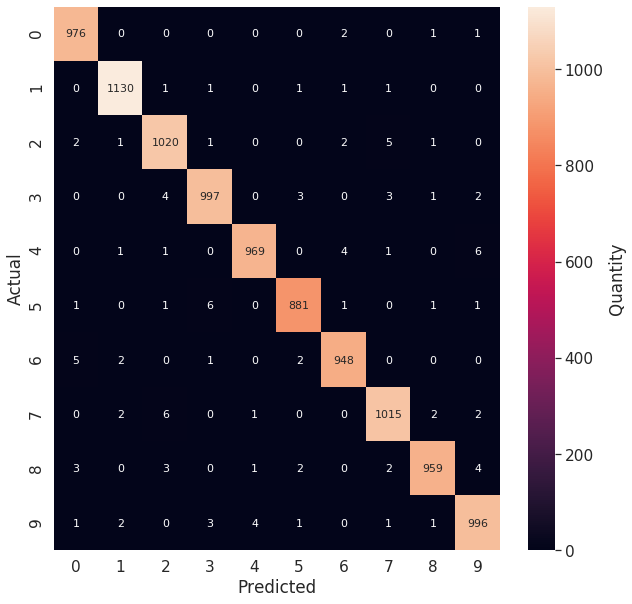

In [40]:
# Plots the confusion matrix for the trained VGG-16 model
Tuned_y_pred, Tuned_y_test, Tuned_CM = plotConfusionMatrix("Tuned", model_Tuned, X_test, y_test)

In [41]:
# Prints the classification report based on predicted and actual test dataset labels for the VGG-16 model
Tuned_CR = plotClassificationReport(Tuned_y_pred, Tuned_y_test, names)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [42]:
# Evaluates the accuracy and loss scores for the test dataset using the trained VGG-16 model
Tuned_test_loss, Tuned_test_acc = printTestStats(model_Tuned, X_test, y_test)

Test loss: 7.21
Test accuracy: 98.91


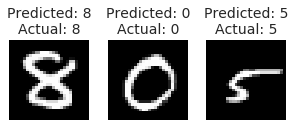

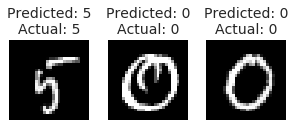

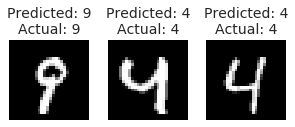

In [43]:
PlotClassifications(model_Tuned, X_test, y_test, misclassified=False)

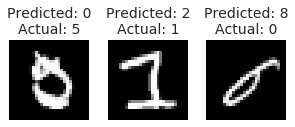

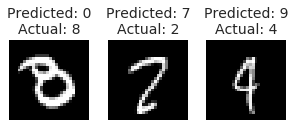

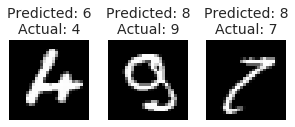

In [44]:
PlotClassifications(model_Tuned, X_test, y_test, misclassified=True)

#### 7.7.1 Tuned Model Visualization

##### 7.7.1.1 Activation Maximization

In [0]:
model_tuned_view = models.clone_model(model_Tuned)
model_tuned_view.build((None, 10)) # replace 10 with number of variables in input layer
model_tuned_view.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_tuned_view.set_weights(model_Tuned.get_weights())

# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model_tuned_view, 'visualized_layer')

# Swap softmax with linear
model_tuned_view.layers[layer_index].activation = activations.linear
model_tuned_view = utils.apply_modifications(model_tuned_view)  

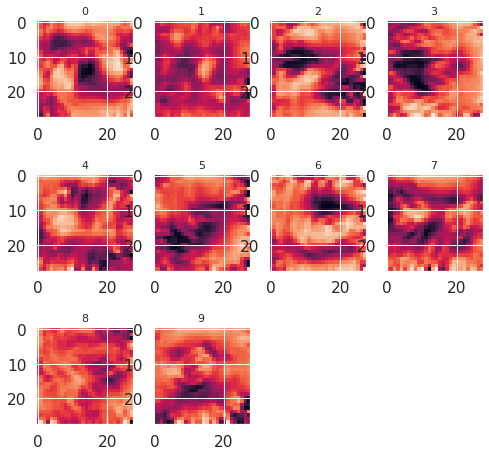

In [46]:
# Numbers to visualize
numbers_to_visualize = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ]

# Visualize
fig=plt.figure(figsize=(8, 8))
for number_to_visualize in numbers_to_visualize:
  fig.add_subplot(3, 4, number_to_visualize + 1)
  visualization = visualize_activation(model_tuned_view, layer_index, filter_indices=number_to_visualize, input_range=(0., 1.))
  plt.imshow(visualization[..., 0])
  plt.title(str(number_to_visualize), fontsize=11)
plt.show()

##### 7.7.1.2 Saliency maps

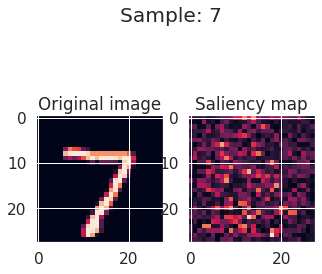

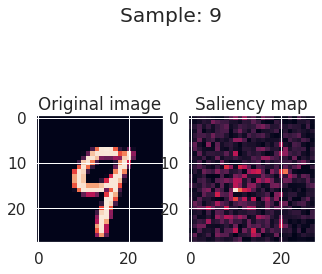

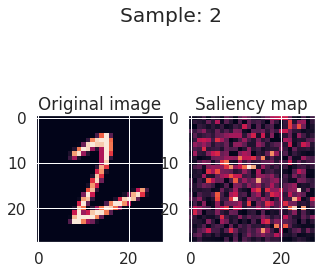

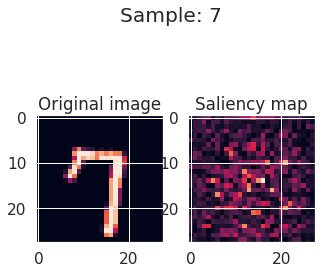

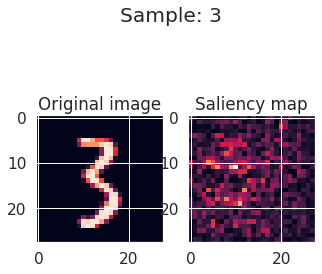

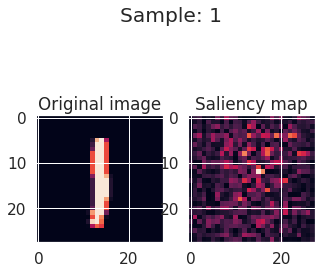

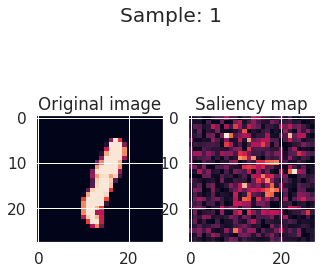

In [47]:
# Numbers to visualize
indices_to_visualize = [ 0, 12, 38, 83, 112, 74, 190 ]

# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
  input_image = X_test[index_to_visualize]
  input_class = np.argmax(y_test[index_to_visualize])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 2)
  # Generate visualization
  visualization = visualize_saliency(model_tuned_view, layer_index, filter_indices=input_class, seed_input=input_image)
  axes[0].imshow(input_image[..., 0]) 
  axes[0].set_title('Original image')
  axes[1].imshow(visualization)
  axes[1].set_title('Saliency map')
  fig.suptitle("Sample: " + str(input_class))
  plt.show()

##### 7.7.1.3 Grad-CAM Class Activation Maps

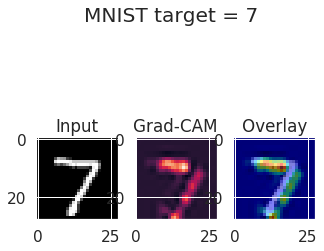

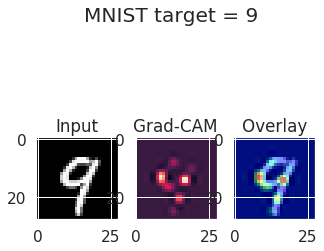

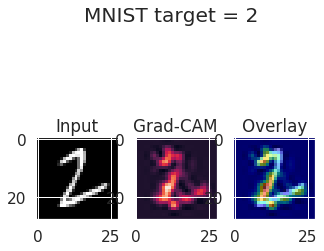

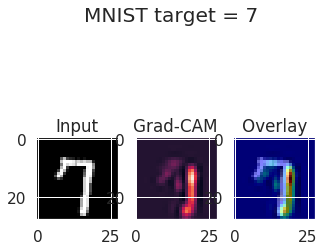

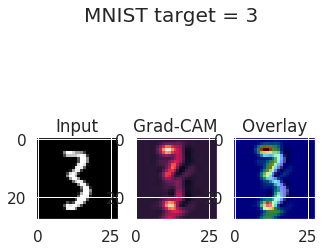

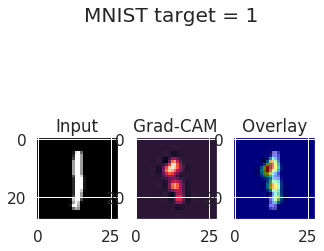

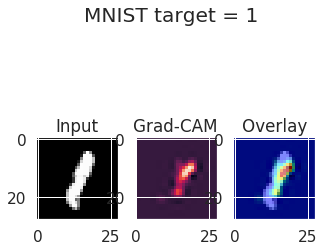

In [48]:
# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
  input_image = X_test[index_to_visualize]
  input_class = np.argmax(y_test[index_to_visualize])
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  # Generate visualization
  visualization = visualize_cam(model_tuned_view, layer_index, filter_indices=input_class, seed_input=input_image)
  axes[0].imshow(input_image[..., 0], cmap='gray') 
  axes[0].set_title('Input')
  axes[1].imshow(visualization)
  axes[1].set_title('Grad-CAM')
  heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
  original = np.uint8(cm.gray(input_image[..., 0])[..., :3] * 255)
  axes[2].imshow(overlay(heatmap, original))
  axes[2].set_title('Overlay')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()

### 7.8. Tuned/Original Model Comparison

#### 7.8.1. Evaluation Helper Functions

In [0]:
def getEvaluationPlot(PltBar, cNames, cLabels):
  idx = [i for i, _ in enumerate(cNames)]

  df = pd.DataFrame(PltBar,
                    index=cLabels,
                    columns=pd.Index(cNames, 
                    name='Algorithm')).round(2)

  df.plot(kind='bar',figsize=(8,4))

  ax = plt.gca()
  ax.set_facecolor('white')
  ax.spines['left'].set_color('black')
  ax.spines['bottom'].set_color('black')
  pos = []
  for bar in ax.patches:
    pos.append(bar.get_x()+bar.get_width()/2.1)

    ax.set_xticks(pos,minor=True)
    lab = []
    for i in range(len(pos)):
      l = df.columns.values[i//len(df.index.values)]
      lab.append(l)
    ax.set_xticklabels(lab,minor=True, rotation=90, size=12)
    ax.tick_params(axis='x', which='major', pad=60, size=0)
    #ax.legend(loc='upper right', frameon=False)
    plt.setp(ax.get_xticklabels(), rotation=0)

  ax.legend().set_visible(False)
  plt.show()

#### 7.8.2. Evaluation

In [0]:
cNames = ["Custom", "Tuned"]

cms = [Custom_CM, Tuned_CM]
crs = [Custom_CR, Tuned_CR]
testloss_scores = [Custom_test_loss, Tuned_test_loss]
testacc_scores = [Custom_test_acc, Tuned_test_acc]

##### 7.8.2.1. Evaluate Classification Scores 

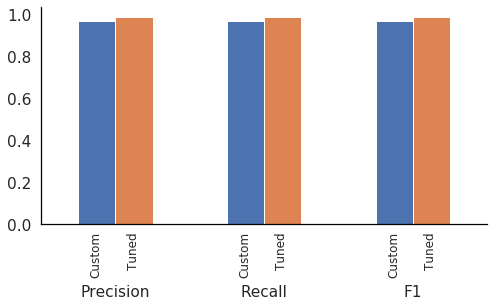

In [51]:
Precisions = [df.loc[df['class'] == 'MacroAvg']['precision'].values[0] for df in crs]
Recalls = [df.loc[df['class'] == 'MacroAvg']['recall'].values[0] for df in crs]
F1s = [df.loc[df['class'] == 'MacroAvg']['f1_score'].values[0] for df in crs]

cLabels = ['Precision', 'Recall', 'F1']
PltBar = [Precisions, Recalls, F1s]

getEvaluationPlot(PltBar, cNames, cLabels)

##### 7.8.2.2. Evaluate Test Loss/Accuracy Scores

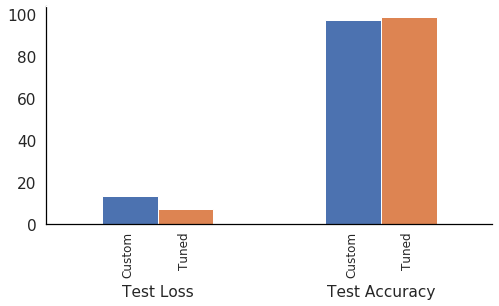

In [52]:
cLabels = ['Test Loss', 'Test Accuracy']
PltBar = [testloss_scores, testacc_scores]

getEvaluationPlot(PltBar, cNames, cLabels)

## 8. References

- [Convolutional Neural Networks (CNN) explained](https://pylessons.com/Keras-ResNet-tutorial/)
- [How to Visualize a Deep Learning Neural Network Model in Keras](https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/)
- [How to Visualize Filters and Feature Maps in Convolutional Neural Networks](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)
- [Visualize Keras models: overview of visualization methods & tools](https://www.machinecurve.com/index.php/2019/12/03/visualize-keras-models-overview-of-visualization-methods-tools/)



